In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=0

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True,with_l4=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
from sklearn.linear_model import Ridge

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=['weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0', 'const_one', 'visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean', 'genre_name_visitors_mean', 'day_of_week_visitors_mean', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'visitor_ma2', 'visitor_ma4', 'visitor_ma7', 'visitor_ma14', 'visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 'visitor_sma2', 'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16', 'visitor_sma32', 'visitors_minus_ma28', 'visitors_divid_ma28', 'all_count_y1', 'geo1_count_y1', 'station_count_y1', 'geo2_count_y1', 'all_count_y2', 'geo1_count_y2', 'station_count_y2', 'geo2_count_y2', 'all_count_y3', 'geo1_count_y3', 'station_count_y3', 'geo2_count_y3', 'all_count_y4', 'geo1_count_y4', 'station_count_y4', 'geo2_count_y4', 'all_count_y5', 'geo1_count_y5', 'station_count_y5', 'geo2_count_y5', 'TMAX', 'TMIN', 'TAVG', 'PRCP', 'holiday', 's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio', 'f_t', 'bad_ratio', 'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean']
len(lag_cols)

72

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                        ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl',
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        gbm = Ridge(alpha=3)
        gbm.fit(trainX,trainy)

        models.append(gbm)
        validpred=gbm.predict(validX)
        scores.append(mean_squared_error(validy,validpred))
        print mean_squared_error(trainy,gbm.predict(trainX)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        X=np.concatenate([X,np.isnan(X)],1)
        X[np.isnan(X)]=0        
        pred=model.predict(X).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
pickle.dump(validpreds, open('l4_3000_ridge_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1566
0
(200571, 1, 36) (200571, 7, 72) (200571, 1) (200571, 1)
(200571, 540) (200571,) (200571,)
(50169, 1, 36) (50169, 7, 72) (50169, 1) (50169, 1)
(50169, 540) (50169,) (50169,)
(5803, 1, 36) (5803, 7, 72) (5803, 1) (5803, 1)
(5803, 540) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.68108362972e-11 / 5.96046447754e-08
  RuntimeWarning)


0.24334848 0.23674648
[0.23674648]
-1 mean score 0.23674648
0.213928803802


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.928584  0.000526  0.230375    7  2017-04-16
472     2.507290  2.537174 -0.029883  0.236324    1  2017-04-17
473     2.661330  2.668270 -0.006940  0.249552    2  2017-04-18
474     2.754815  2.743780  0.011034  0.206486    3  2017-04-19
475     2.713762  2.715120 -0.001358  0.232209    4  2017-04-20
476     2.999000  2.989780  0.009219  0.156339    5  2017-04-21
477     3.075529  3.075852 -0.000323  0.186217    6  2017-04-22

0.213928803802


pred         y     error    error2  day        date
dayidx                                                         
471     2.928584  2.929110  0.000526  0.230375    7  2017-04-16
472     2.537174  2.507290 -0.029883  0.236324    1  2017-04-17
473     2.668270  2.661330 -0.006940  0.249552    2  2017-04-18
474     2.743780  2.754815  0.011034  0.206486    3  2017-04-19
475     2.715120  2.713762 -0.001358  0.232209    4  2017-04-20
476     2.989780  2.999000  0.009219  0.156339    5  2017-04-21
477     3.075852  3.075529 -0.000323  0.186217    6  2017-04-22

(829, 1080)


2
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200346, 2) (50111, 2)
train/valid # (200346, 2) (50111, 2)
rand split across time
train has 200346 records out of 389630 records
valid has 50111 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1565
0
(200346, 1, 36) (200346, 7, 72) (200346, 1) (200346, 1)
(200346, 540) (200346,) (200346,)
(50111, 1, 36) (50111, 7, 72) (50111, 1) (50111, 1)
(50111, 540) (50111,) (50111,)
(6632, 1, 36) (6632, 7, 72) (6632, 1) (6632, 1)
(6632, 540) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.37873720721e-10 / 5.96046447754e-08
  RuntimeWarning)


0.24804695 0.24158426
[0.24158426]
-1 mean score 0.24158426
0.21688400209


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915295  0.013815  0.235004    7  2017-04-16
472     2.507290  2.537285 -0.029994  0.237417    1  2017-04-17
473     2.661330  2.676720 -0.015390  0.251524    2  2017-04-18
474     2.754815  2.759652 -0.004838  0.212275    3  2017-04-19
475     2.713762  2.719655 -0.005893  0.237146    4  2017-04-20
476     2.999000  2.979525  0.019474  0.159455    5  2017-04-21
477     3.075529  3.070010  0.005519  0.185367    6  2017-04-22

0.21688400209


pred         y     error    error2  day        date
dayidx                                                         
471     2.915295  2.929110  0.013815  0.235004    7  2017-04-16
472     2.537285  2.507290 -0.029994  0.237417    1  2017-04-17
473     2.676720  2.661330 -0.015390  0.251524    2  2017-04-18
474     2.759652  2.754815 -0.004838  0.212275    3  2017-04-19
475     2.719655  2.713762 -0.005893  0.237146    4  2017-04-20
476     2.979525  2.999000  0.019474  0.159455    5  2017-04-21
477     3.070010  3.075529  0.005519  0.185367    6  2017-04-22

(829, 1080)


3
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200167, 2) (50063, 2)
train/valid # (200167, 2) (50063, 2)
rand split across time
train has 200167 records out of 389630 records
valid has 50063 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1563
0
(200167, 1, 36) (200167, 7, 72) (200167, 1) (200167, 1)
(200167, 540) (200167,) (200167,)
(50063, 1, 36) (50063, 7, 72) (50063, 1) (50063, 1)
(50063, 540) (50063,) (50063,)
(7461, 1, 36) (7461, 7, 72) (7461, 1) (7461, 1)
(7461, 540) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.21986934443e-10 / 5.96046447754e-08
  RuntimeWarning)


0.24992384 0.24381551
[0.24381551]
-1 mean score 0.24381551
0.221438154578


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893505  0.035605  0.234979    7  2017-04-16
472     2.507290  2.517074 -0.009784  0.238453    1  2017-04-17
473     2.661330  2.657511  0.003819  0.263258    2  2017-04-18
474     2.754815  2.771413 -0.016598  0.221608    3  2017-04-19
475     2.713762  2.724928 -0.011166  0.240975    4  2017-04-20
476     2.999000  2.969790  0.029210  0.161768    5  2017-04-21
477     3.075529  3.059614  0.015915  0.189028    6  2017-04-22

0.221438154578


pred         y     error    error2  day        date
dayidx                                                         
471     2.893505  2.929110  0.035605  0.234979    7  2017-04-16
472     2.517074  2.507290 -0.009784  0.238453    1  2017-04-17
473     2.657511  2.661330  0.003819  0.263258    2  2017-04-18
474     2.771412  2.754815 -0.016598  0.221608    3  2017-04-19
475     2.724928  2.713762 -0.011166  0.240975    4  2017-04-20
476     2.969790  2.999000  0.029210  0.161768    5  2017-04-21
477     3.059614  3.075529  0.015915  0.189028    6  2017-04-22

(829, 1080)


4
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (200008, 2) (50020, 2)
train/valid # (200008, 2) (50020, 2)
rand split across time
train has 200008 records out of 389630 records
valid has 50020 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1562
0
(200008, 1, 36) (200008, 7, 72) (200008, 1) (200008, 1)
(200008, 540) (200008,) (200008,)
(50020, 1, 36) (50020, 7, 72) (50020, 1) (50020, 1)
(50020, 540) (50020,) (50020,)
(8290, 1, 36) (8290, 7, 72) (8290, 1) (8290, 1)
(8290, 540) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.21339216452e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25152797 0.24520765
[0.24520765]
-1 mean score 0.24520765
0.221869841218


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901764  0.027346  0.241613    7  2017-04-16
472     2.507290  2.514961 -0.007671  0.237392    1  2017-04-17
473     2.661330  2.633188  0.028142  0.261004    2  2017-04-18
474     2.754815  2.747745  0.007069  0.216250    3  2017-04-19
475     2.713762  2.722257 -0.008495  0.242519    4  2017-04-20
476     2.999000  2.953370  0.045630  0.167310    5  2017-04-21
477     3.075529  3.051981  0.023548  0.187000    6  2017-04-22

0.221869826317


pred         y     error    error2  day        date
dayidx                                                         
471     2.901764  2.929110  0.027346  0.241613    7  2017-04-16
472     2.514961  2.507290 -0.007671  0.237392    1  2017-04-17
473     2.633188  2.661330  0.028142  0.261004    2  2017-04-18
474     2.747745  2.754815  0.007069  0.216250    3  2017-04-19
475     2.722257  2.713762 -0.008495  0.242519    4  2017-04-20
476     2.953370  2.999000  0.045630  0.167310    5  2017-04-21
477     3.051981  3.075529  0.023548  0.187000    6  2017-04-22

(829, 1080)


5
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199805, 2) (49971, 2)
train/valid # (199805, 2) (49971, 2)
rand split across time
train has 199805 records out of 389630 records
valid has 49971 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1560
0
(199805, 1, 36) (199805, 7, 72) (199805, 1) (199805, 1)
(199805, 540) (199805,) (199805,)
(49971, 1, 36) (49971, 7, 72) (49971, 1) (49971, 1)
(49971, 540) (49971,) (49971,)
(9119, 1, 36) (9119, 7, 72) (9119, 1) (9119, 1)
(9119, 540) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.15462348016e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25322574 0.24729563
[0.24729563]
-1 mean score 0.24729563
0.22382850945


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907255  0.021855  0.236234    7  2017-04-16
472     2.507290  2.526122 -0.018831  0.244690    1  2017-04-17
473     2.661330  2.627364  0.033966  0.263202    2  2017-04-18
474     2.754815  2.728539  0.026276  0.215742    3  2017-04-19
475     2.713762  2.702295  0.011467  0.248158    4  2017-04-20
476     2.999000  2.956857  0.042143  0.169805    5  2017-04-21
477     3.075529  3.047616  0.027913  0.188968    6  2017-04-22

0.223828524351


pred         y     error    error2  day        date
dayidx                                                         
471     2.907255  2.929110  0.021855  0.236234    7  2017-04-16
472     2.526122  2.507290 -0.018831  0.244690    1  2017-04-17
473     2.627364  2.661330  0.033966  0.263202    2  2017-04-18
474     2.728539  2.754815  0.026276  0.215742    3  2017-04-19
475     2.702295  2.713762  0.011467  0.248158    4  2017-04-20
476     2.956857  2.999000  0.042143  0.169805    5  2017-04-21
477     3.047616  3.075529  0.027913  0.188968    6  2017-04-22

(829, 1080)


6
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 15.133374
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199592, 2) (49921, 2)
train/valid # (199592, 2) (49921, 2)
rand split across time
train has 199592 records out of 389630 records
valid has 49921 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1559
0
(199592, 1, 36) (199592, 7, 72) (199592, 1) (199592, 1)
(199592, 540) (199592,) (199592,)
(49921, 1, 36) (49921, 7, 72) (49921, 1) (49921, 1)
(49921, 540) (49921,) (49921,)
(9948, 1, 36) (9948, 7, 72) (9948, 1) (9948, 1)
(9948, 540) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.46328041298e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25418967 0.24804011
[0.24804011]
-1 mean score 0.24804011
0.227216884494


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917228  0.011882  0.243391    7  2017-04-16
472     2.507290  2.533016 -0.025726  0.251284    1  2017-04-17
473     2.661330  2.630455  0.030875  0.270455    2  2017-04-18
474     2.754815  2.734737  0.020078  0.217777    3  2017-04-19
475     2.713762  2.720247 -0.006486  0.248731    4  2017-04-20
476     2.999000  2.942782  0.056218  0.171155    5  2017-04-21
477     3.075529  3.065963  0.009566  0.187725    6  2017-04-22

0.227216854692


pred         y     error    error2  day        date
dayidx                                                         
471     2.917228  2.929110  0.011882  0.243391    7  2017-04-16
472     2.533016  2.507290 -0.025726  0.251284    1  2017-04-17
473     2.630455  2.661330  0.030875  0.270455    2  2017-04-18
474     2.734737  2.754815  0.020078  0.217777    3  2017-04-19
475     2.720247  2.713762 -0.006486  0.248731    4  2017-04-20
476     2.942782  2.999000  0.056218  0.171155    5  2017-04-21
477     3.065963  3.075529  0.009566  0.187725    6  2017-04-22

(829, 1080)


7
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 16.310143
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199370, 2) (49869, 2)
train/valid # (199370, 2) (49869, 2)
rand split across time
train has 199370 records out of 389630 records
valid has 49869 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1557
0
(199370, 1, 36) (199370, 7, 72) (199370, 1) (199370, 1)
(199370, 540) (199370,) (199370,)
(49869, 1, 36) (49869, 7, 72) (49869, 1) (49869, 1)
(49869, 540) (49869,) (49869,)
(10777, 1, 36) (10777, 7, 72) (10777, 1) (10777, 1)
(10777, 540) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.98974170473e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25647023 0.25103658
[0.25103658]
-1 mean score 0.25103658
0.228024885058


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912219  0.016891  0.245770    7  2017-04-16
472     2.507290  2.541426 -0.034136  0.251771    1  2017-04-17
473     2.661330  2.632901  0.028429  0.272119    2  2017-04-18
474     2.754815  2.724930  0.029884  0.218645    3  2017-04-19
475     2.713762  2.711681  0.002080  0.251132    4  2017-04-20
476     2.999000  2.968694  0.030306  0.165006    5  2017-04-21
477     3.075529  3.088338 -0.012809  0.191731    6  2017-04-22

0.228024885058


pred         y     error    error2  day        date
dayidx                                                         
471     2.912220  2.929110  0.016891  0.245770    7  2017-04-16
472     2.541426  2.507290 -0.034136  0.251771    1  2017-04-17
473     2.632901  2.661330  0.028429  0.272119    2  2017-04-18
474     2.724931  2.754815  0.029884  0.218645    3  2017-04-19
475     2.711681  2.713762  0.002080  0.251132    4  2017-04-20
476     2.968694  2.999000  0.030306  0.165006    5  2017-04-21
477     3.088338  3.075529 -0.012809  0.191731    6  2017-04-22

(829, 1080)


8
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 17.574337
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (199138, 2) (49811, 2)
train/valid # (199138, 2) (49811, 2)
rand split across time
train has 199138 records out of 389630 records
valid has 49811 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1555
0
(199138, 1, 36) (199138, 7, 72) (199138, 1) (199138, 1)
(199138, 540) (199138,) (199138,)
(49811, 1, 36) (49811, 7, 72) (49811, 1) (49811, 1)
(49811, 540) (49811,) (49811,)
(11606, 1, 36) (11606, 7, 72) (11606, 1) (11606, 1)
(11606, 540) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.08142182709e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26028657 0.25607693
[0.25607693]
-1 mean score 0.25607693
0.233008831739


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.935279 -0.006169  0.254827    7  2017-04-16
472     2.507290  2.548628 -0.041337  0.248701    1  2017-04-17
473     2.661330  2.651899  0.009431  0.276537    2  2017-04-18
474     2.754815  2.730690  0.024125  0.230201    3  2017-04-19
475     2.713762  2.714677 -0.000916  0.254795    4  2017-04-20
476     2.999000  2.957968  0.041031  0.174160    5  2017-04-21
477     3.075529  3.087949 -0.012420  0.191841    6  2017-04-22

0.233008831739


pred         y     error    error2  day        date
dayidx                                                         
471     2.935279  2.929110 -0.006169  0.254827    7  2017-04-16
472     2.548628  2.507290 -0.041337  0.248702    1  2017-04-17
473     2.651899  2.661330  0.009431  0.276537    2  2017-04-18
474     2.730690  2.754815  0.024125  0.230201    3  2017-04-19
475     2.714678  2.713762 -0.000916  0.254795    4  2017-04-20
476     2.957968  2.999000  0.041031  0.174160    5  2017-04-21
477     3.087949  3.075529 -0.012420  0.191841    6  2017-04-22

(829, 1080)


9
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 18.806503
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198911, 2) (49756, 2)
train/valid # (198911, 2) (49756, 2)
rand split across time
train has 198911 records out of 389630 records
valid has 49756 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1553
0
(198911, 1, 36) (198911, 7, 72) (198911, 1) (198911, 1)
(198911, 540) (198911,) (198911,)
(49756, 1, 36) (49756, 7, 72) (49756, 1) (49756, 1)
(49756, 540) (49756,) (49756,)
(12435, 1, 36) (12435, 7, 72) (12435, 1) (12435, 1)
(12435, 540) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.13891937548e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2622335 0.25752297
[0.25752297]
-1 mean score 0.25752297
0.232239574194


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919196  0.009914  0.255804    7  2017-04-16
472     2.507290  2.548708 -0.041417  0.248280    1  2017-04-17
473     2.661330  2.671547 -0.010217  0.277692    2  2017-04-18
474     2.754815  2.728953  0.025862  0.231680    3  2017-04-19
475     2.713762  2.716834 -0.003072  0.249492    4  2017-04-20
476     2.999000  2.964648  0.034351  0.171224    5  2017-04-21
477     3.075529  3.079060 -0.003531  0.191504    6  2017-04-22

0.232239589095


pred         y     error    error2  day        date
dayidx                                                         
471     2.919196  2.929110  0.009914  0.255804    7  2017-04-16
472     2.548708  2.507290 -0.041417  0.248280    1  2017-04-17
473     2.671547  2.661330 -0.010217  0.277692    2  2017-04-18
474     2.728953  2.754815  0.025862  0.231680    3  2017-04-19
475     2.716834  2.713762 -0.003072  0.249492    4  2017-04-20
476     2.964648  2.999000  0.034351  0.171224    5  2017-04-21
477     3.079060  3.075529 -0.003531  0.191504    6  2017-04-22

(829, 1080)


10
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 19.926521
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198741, 2) (49710, 2)
train/valid # (198741, 2) (49710, 2)
rand split across time
train has 198741 records out of 389630 records
valid has 49710 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1552
0
(198741, 1, 36) (198741, 7, 72) (198741, 1) (198741, 1)
(198741, 540) (198741,) (198741,)
(49710, 1, 36) (49710, 7, 72) (49710, 1) (49710, 1)
(49710, 540) (49710,) (49710,)
(13264, 1, 36) (13264, 7, 72) (13264, 1) (13264, 1)
(13264, 540) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.18509563274e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26276332 0.2588933
[0.2588933]
-1 mean score 0.2588933
0.231561332941


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922101  0.007009  0.251515    7  2017-04-16
472     2.507290  2.529954 -0.022664  0.248152    1  2017-04-17
473     2.661330  2.672404 -0.011074  0.278958    2  2017-04-18
474     2.754815  2.745900  0.008914  0.227816    3  2017-04-19
475     2.713762  2.724098 -0.010337  0.250387    4  2017-04-20
476     2.999000  2.970497  0.028502  0.171917    5  2017-04-21
477     3.075529  3.088225 -0.012695  0.192185    6  2017-04-22

0.231561303139


pred         y     error    error2  day        date
dayidx                                                         
471     2.922101  2.929110  0.007009  0.251516    7  2017-04-16
472     2.529954  2.507290 -0.022664  0.248152    1  2017-04-17
473     2.672404  2.661330 -0.011074  0.278958    2  2017-04-18
474     2.745900  2.754815  0.008914  0.227816    3  2017-04-19
475     2.724098  2.713762 -0.010337  0.250387    4  2017-04-20
476     2.970497  2.999000  0.028502  0.171917    5  2017-04-21
477     3.088225  3.075529 -0.012695  0.192185    6  2017-04-22

(829, 1080)


11
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 21.05768
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198559, 2) (49666, 2)
train/valid # (198559, 2) (49666, 2)
rand split across time
train has 198559 records out of 389630 records
valid has 49666 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1551
0
(198559, 1, 36) (198559, 7, 72) (198559, 1) (198559, 1)
(198559, 540) (198559,) (198559,)
(49666, 1, 36) (49666, 7, 72) (49666, 1) (49666, 1)
(49666, 540) (49666,) (49666,)
(14093, 1, 36) (14093, 7, 72) (14093, 1) (14093, 1)
(14093, 540) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.24533550139e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2635235 0.25950027
[0.25950027]
-1 mean score 0.25950027
0.231974869967


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911572  0.017538  0.250164    7  2017-04-16
472     2.507290  2.533933 -0.026643  0.249632    1  2017-04-17
473     2.661330  2.662969 -0.001639  0.279919    2  2017-04-18
474     2.754815  2.726443  0.028372  0.228690    3  2017-04-19
475     2.713762  2.733175 -0.019413  0.250020    4  2017-04-20
476     2.999000  2.977206  0.021793  0.173028    5  2017-04-21
477     3.075529  3.071066  0.004463  0.192370    6  2017-04-22

0.231974869967


pred         y     error    error2  day        date
dayidx                                                         
471     2.911572  2.929110  0.017538  0.250164    7  2017-04-16
472     2.533933  2.507290 -0.026643  0.249632    1  2017-04-17
473     2.662969  2.661330 -0.001639  0.279919    2  2017-04-18
474     2.726443  2.754815  0.028372  0.228690    3  2017-04-19
475     2.733175  2.713762 -0.019413  0.250020    4  2017-04-20
476     2.977206  2.999000  0.021793  0.173028    5  2017-04-21
477     3.071066  3.075529  0.004463  0.192370    6  2017-04-22

(829, 1080)


12
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 22.115147
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198344, 2) (49614, 2)
train/valid # (198344, 2) (49614, 2)
rand split across time
train has 198344 records out of 389630 records
valid has 49614 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1549
0
(198344, 1, 36) (198344, 7, 72) (198344, 1) (198344, 1)
(198344, 540) (198344,) (198344,)
(49614, 1, 36) (49614, 7, 72) (49614, 1) (49614, 1)
(49614, 540) (49614,) (49614,)
(14922, 1, 36) (14922, 7, 72) (14922, 1) (14922, 1)
(14922, 540) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1747122719e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26522467 0.26074612
[0.26074612]
-1 mean score 0.26074612
0.232964754105


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900006  0.029104  0.253522    7  2017-04-16
472     2.507290  2.544111 -0.036820  0.249586    1  2017-04-17
473     2.661330  2.668539 -0.007209  0.276440    2  2017-04-18
474     2.754815  2.723723  0.031092  0.231676    3  2017-04-19
475     2.713762  2.742287 -0.028525  0.250160    4  2017-04-20
476     2.999000  2.978622  0.020378  0.175732    5  2017-04-21
477     3.075529  3.079592 -0.004063  0.193638    6  2017-04-22

0.232964739203


pred         y     error    error2  day        date
dayidx                                                         
471     2.900006  2.929110  0.029104  0.253522    7  2017-04-16
472     2.544111  2.507290 -0.036820  0.249586    1  2017-04-17
473     2.668539  2.661330 -0.007209  0.276440    2  2017-04-18
474     2.723723  2.754815  0.031092  0.231676    3  2017-04-19
475     2.742287  2.713762 -0.028525  0.250160    4  2017-04-20
476     2.978622  2.999000  0.020378  0.175732    5  2017-04-21
477     3.079592  3.075529 -0.004063  0.193638    6  2017-04-22

(829, 1080)


13
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 23.15517
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (198132, 2) (49563, 2)
train/valid # (198132, 2) (49563, 2)
rand split across time
train has 198132 records out of 389630 records
valid has 49563 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1547
0
(198132, 1, 36) (198132, 7, 72) (198132, 1) (198132, 1)
(198132, 540) (198132,) (198132,)
(49563, 1, 36) (49563, 7, 72) (49563, 1) (49563, 1)
(49563, 540) (49563,) (49563,)
(15751, 1, 36) (15751, 7, 72) (15751, 1) (15751, 1)
(15751, 540) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.14603987359e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26587686 0.26237133
[0.26237133]
-1 mean score 0.26237133
0.234547510743


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904199  0.024911  0.258633    7  2017-04-16
472     2.507290  2.526050 -0.018759  0.255046    1  2017-04-17
473     2.661330  2.675632 -0.014302  0.278041    2  2017-04-18
474     2.754815  2.728926  0.025888  0.234218    3  2017-04-19
475     2.713762  2.740885 -0.027123  0.252474    4  2017-04-20
476     2.999000  3.010957 -0.011958  0.173392    5  2017-04-21
477     3.075529  3.069856  0.005673  0.190028    6  2017-04-22

0.234547510743


pred         y     error    error2  day        date
dayidx                                                         
471     2.904199  2.929110  0.024911  0.258633    7  2017-04-16
472     2.526050  2.507290 -0.018759  0.255046    1  2017-04-17
473     2.675632  2.661330 -0.014302  0.278041    2  2017-04-18
474     2.728926  2.754815  0.025888  0.234218    3  2017-04-19
475     2.740885  2.713762 -0.027123  0.252474    4  2017-04-20
476     3.010957  2.999000 -0.011958  0.173392    5  2017-04-21
477     3.069856  3.075529  0.005673  0.190028    6  2017-04-22

(829, 1080)


14
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 24.22639
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197911, 2) (49506, 2)
train/valid # (197911, 2) (49506, 2)
rand split across time
train has 197911 records out of 389630 records
valid has 49506 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1546
0
(197911, 1, 36) (197911, 7, 72) (197911, 1) (197911, 1)
(197911, 540) (197911,) (197911,)
(49506, 1, 36) (49506, 7, 72) (49506, 1) (49506, 1)
(49506, 540) (49506,) (49506,)
(16580, 1, 36) (16580, 7, 72) (16580, 1) (16580, 1)
(16580, 540) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.97083072084e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2669824 0.2637179
[0.2637179]
-1 mean score 0.2637179
0.234399408102


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907441  0.021668  0.260786    7  2017-04-16
472     2.507290  2.518489 -0.011198  0.250909    1  2017-04-17
473     2.661330  2.664159 -0.002830  0.280275    2  2017-04-18
474     2.754815  2.721823  0.032992  0.236418    3  2017-04-19
475     2.713762  2.736636 -0.022875  0.248798    4  2017-04-20
476     2.999000  3.014532 -0.015532  0.167187    5  2017-04-21
477     3.075529  3.083797 -0.008267  0.196423    6  2017-04-22

0.234399393201


pred         y     error    error2  day        date
dayidx                                                         
471     2.907442  2.929110  0.021668  0.260786    7  2017-04-16
472     2.518489  2.507290 -0.011199  0.250909    1  2017-04-17
473     2.664159  2.661330 -0.002830  0.280275    2  2017-04-18
474     2.721823  2.754815  0.032992  0.236418    3  2017-04-19
475     2.736636  2.713762 -0.022875  0.248798    4  2017-04-20
476     3.014532  2.999000 -0.015532  0.167187    5  2017-04-21
477     3.083797  3.075529 -0.008267  0.196423    6  2017-04-22

(829, 1080)


15
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 25.357664
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197678, 2) (49449, 2)
train/valid # (197678, 2) (49449, 2)
rand split across time
train has 197678 records out of 389630 records
valid has 49449 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1544
0
(197678, 1, 36) (197678, 7, 72) (197678, 1) (197678, 1)
(197678, 540) (197678,) (197678,)
(49449, 1, 36) (49449, 7, 72) (49449, 1) (49449, 1)
(49449, 540) (49449,) (49449,)
(17409, 1, 36) (17409, 7, 72) (17409, 1) (17409, 1)
(17409, 540) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.90908455711e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27044454 0.26677868
[0.26677868]
-1 mean score 0.26677868
0.240063816309


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903208  0.025902  0.270209    7  2017-04-16
472     2.507290  2.528250 -0.020959  0.253445    1  2017-04-17
473     2.661330  2.649544  0.011786  0.290875    2  2017-04-18
474     2.754815  2.713677  0.041137  0.235535    3  2017-04-19
475     2.713762  2.739501 -0.025740  0.258044    4  2017-04-20
476     2.999000  3.010248 -0.011249  0.175313    5  2017-04-21
477     3.075529  3.078384 -0.002855  0.197025    6  2017-04-22

0.240063816309


pred         y     error    error2  day        date
dayidx                                                         
471     2.903208  2.929110  0.025902  0.270209    7  2017-04-16
472     2.528250  2.507290 -0.020959  0.253445    1  2017-04-17
473     2.649544  2.661330  0.011786  0.290875    2  2017-04-18
474     2.713677  2.754815  0.041137  0.235535    3  2017-04-19
475     2.739501  2.713762 -0.025740  0.258044    4  2017-04-20
476     3.010248  2.999000 -0.011249  0.175313    5  2017-04-21
477     3.078384  3.075529 -0.002855  0.197025    6  2017-04-22

(829, 1080)


16
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 26.465925
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197447, 2) (49391, 2)
train/valid # (197447, 2) (49391, 2)
rand split across time
train has 197447 records out of 389630 records
valid has 49391 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1542
0
(197447, 1, 36) (197447, 7, 72) (197447, 1) (197447, 1)
(197447, 540) (197447,) (197447,)
(49391, 1, 36) (49391, 7, 72) (49391, 1) (49391, 1)
(49391, 540) (49391,) (49391,)
(18238, 1, 36) (18238, 7, 72) (18238, 1) (18238, 1)
(18238, 540) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.91319446396e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27215967 0.26942524
[0.26942524]
-1 mean score 0.26942524
0.240848764777


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897031  0.032079  0.271304    7  2017-04-16
472     2.507290  2.537505 -0.030215  0.256387    1  2017-04-17
473     2.661330  2.643022  0.018307  0.291186    2  2017-04-18
474     2.754815  2.707022  0.047793  0.236777    3  2017-04-19
475     2.713762  2.731252 -0.017491  0.257116    4  2017-04-20
476     2.999000  3.001548 -0.002548  0.177903    5  2017-04-21
477     3.075529  3.064654  0.010875  0.195268    6  2017-04-22

0.240848764777


pred         y     error    error2  day        date
dayidx                                                         
471     2.897031  2.929110  0.032079  0.271304    7  2017-04-16
472     2.537505  2.507290 -0.030215  0.256387    1  2017-04-17
473     2.643022  2.661330  0.018307  0.291186    2  2017-04-18
474     2.707022  2.754815  0.047793  0.236777    3  2017-04-19
475     2.731252  2.713762 -0.017491  0.257116    4  2017-04-20
476     3.001548  2.999000 -0.002548  0.177903    5  2017-04-21
477     3.064654  3.075529  0.010875  0.195268    6  2017-04-22

(829, 1080)


17
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 27.605818
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197289, 2) (49347, 2)
train/valid # (197289, 2) (49347, 2)
rand split across time
train has 197289 records out of 389630 records
valid has 49347 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1541
0
(197289, 1, 36) (197289, 7, 72) (197289, 1) (197289, 1)
(197289, 540) (197289,) (197289,)
(49347, 1, 36) (49347, 7, 72) (49347, 1) (49347, 1)
(49347, 540) (49347,) (49347,)
(19067, 1, 36) (19067, 7, 72) (19067, 1) (19067, 1)
(19067, 540) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.75252587021e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27314585 0.26989472
[0.26989472]
-1 mean score 0.26989472
0.242126330733


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902310  0.026800  0.269832    7  2017-04-16
472     2.507290  2.519948 -0.012657  0.257039    1  2017-04-17
473     2.661330  2.635805  0.025525  0.291288    2  2017-04-18
474     2.754815  2.702052  0.052763  0.247284    3  2017-04-19
475     2.713762  2.723768 -0.010007  0.255479    4  2017-04-20
476     2.999000  2.996092  0.002908  0.178933    5  2017-04-21
477     3.075529  3.060945  0.014584  0.195029    6  2017-04-22

0.242126300931


pred         y     error    error2  day        date
dayidx                                                         
471     2.902310  2.929110  0.026800  0.269832    7  2017-04-16
472     2.519948  2.507290 -0.012657  0.257039    1  2017-04-17
473     2.635805  2.661330  0.025525  0.291288    2  2017-04-18
474     2.702052  2.754815  0.052763  0.247284    3  2017-04-19
475     2.723768  2.713762 -0.010007  0.255479    4  2017-04-20
476     2.996092  2.999000  0.002908  0.178933    5  2017-04-21
477     3.060945  3.075529  0.014584  0.195029    6  2017-04-22

(829, 1080)


18
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 28.75126
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (197099, 2) (49301, 2)
train/valid # (197099, 2) (49301, 2)
rand split across time
train has 197099 records out of 389630 records
valid has 49301 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1539
0
(197099, 1, 36) (197099, 7, 72) (197099, 1) (197099, 1)
(197099, 540) (197099,) (197099,)
(49301, 1, 36) (49301, 7, 72) (49301, 1) (49301, 1)
(49301, 540) (49301,) (49301,)
(19896, 1, 36) (19896, 7, 72) (19896, 1) (19896, 1)
(19896, 540) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.01196190316e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27403194 0.2711366
[0.2711366]
-1 mean score 0.2711366
0.244470700622


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900870  0.028240  0.275625    7  2017-04-16
472     2.507290  2.517260 -0.009969  0.259949    1  2017-04-17
473     2.661330  2.622730  0.038600  0.291242    2  2017-04-18
474     2.754815  2.713743  0.041072  0.238873    3  2017-04-19
475     2.713762  2.732953 -0.019192  0.264738    4  2017-04-20
476     2.999000  2.993470  0.005529  0.180856    5  2017-04-21
477     3.075529  3.058635  0.016894  0.200013    6  2017-04-22

0.244470700622


pred         y     error    error2  day        date
dayidx                                                         
471     2.900870  2.929110  0.028240  0.275625    7  2017-04-16
472     2.517260  2.507290 -0.009969  0.259949    1  2017-04-17
473     2.622730  2.661330  0.038599  0.291242    2  2017-04-18
474     2.713743  2.754815  0.041072  0.238873    3  2017-04-19
475     2.732953  2.713762 -0.019192  0.264738    4  2017-04-20
476     2.993471  2.999000  0.005529  0.180856    5  2017-04-21
477     3.058635  3.075529  0.016894  0.200013    6  2017-04-22

(829, 1080)


19
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 29.798643
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (196885, 2) (49250, 2)
train/valid # (196885, 2) (49250, 2)
rand split across time
train has 196885 records out of 389630 records
valid has 49250 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1538
0
(196885, 1, 36) (196885, 7, 72) (196885, 1) (196885, 1)
(196885, 540) (196885,) (196885,)
(49250, 1, 36) (49250, 7, 72) (49250, 1) (49250, 1)
(49250, 540) (49250,) (49250,)
(20725, 1, 36) (20725, 7, 72) (20725, 1) (20725, 1)
(20725, 540) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1517218429e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27456015 0.27256274
[0.27256274]
-1 mean score 0.27256274
0.247149273753


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.927114  0.001996  0.277231    7  2017-04-16
472     2.507290  2.516957 -0.009666  0.262595    1  2017-04-17
473     2.661330  2.614839  0.046491  0.292007    2  2017-04-18
474     2.754815  2.701458  0.053357  0.244245    3  2017-04-19
475     2.713762  2.712259  0.001503  0.264686    4  2017-04-20
476     2.999000  2.985656  0.013343  0.184358    5  2017-04-21
477     3.075529  3.053064  0.022465  0.204924    6  2017-04-22

0.247149273753


pred         y     error    error2  day        date
dayidx                                                         
471     2.927114  2.929110  0.001996  0.277231    7  2017-04-16
472     2.516957  2.507290 -0.009666  0.262595    1  2017-04-17
473     2.614839  2.661330  0.046491  0.292007    2  2017-04-18
474     2.701458  2.754815  0.053357  0.244245    3  2017-04-19
475     2.712259  2.713762  0.001503  0.264686    4  2017-04-20
476     2.985656  2.999000  0.013343  0.184358    5  2017-04-21
477     3.053064  3.075529  0.022465  0.204924    6  2017-04-22

(829, 1080)


20
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 30.796307
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (196665, 2) (49196, 2)
train/valid # (196665, 2) (49196, 2)
rand split across time
train has 196665 records out of 389630 records
valid has 49196 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1536
0
(196665, 1, 36) (196665, 7, 72) (196665, 1) (196665, 1)
(196665, 540) (196665,) (196665,)
(49196, 1, 36) (49196, 7, 72) (49196, 1) (49196, 1)
(49196, 540) (49196,) (49196,)
(21554, 1, 36) (21554, 7, 72) (21554, 1) (21554, 1)
(21554, 540) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.17419612501e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27497682 0.27252212
[0.27252212]
-1 mean score 0.27252212
0.2443048805


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918692  0.010418  0.269666    7  2017-04-16
472     2.507290  2.545543 -0.038253  0.259560    1  2017-04-17
473     2.661330  2.619519  0.041811  0.285835    2  2017-04-18
474     2.754815  2.701966  0.052849  0.244058    3  2017-04-19
475     2.713762  2.713938 -0.000176  0.269078    4  2017-04-20
476     2.999000  2.973131  0.025869  0.180191    5  2017-04-21
477     3.075529  3.066555  0.008974  0.201746    6  2017-04-22

0.244304865599


pred         y     error    error2  day        date
dayidx                                                         
471     2.918692  2.929110  0.010418  0.269666    7  2017-04-16
472     2.545543  2.507290 -0.038253  0.259560    1  2017-04-17
473     2.619519  2.661330  0.041811  0.285835    2  2017-04-18
474     2.701966  2.754815  0.052849  0.244057    3  2017-04-19
475     2.713938  2.713762 -0.000176  0.269078    4  2017-04-20
476     2.973131  2.999000  0.025869  0.180191    5  2017-04-21
477     3.066556  3.075529  0.008974  0.201746    6  2017-04-22

(829, 1080)


21
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 31.792852
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (196439, 2) (49141, 2)
train/valid # (196439, 2) (49141, 2)
rand split across time
train has 196439 records out of 389630 records
valid has 49141 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1534
0
(196439, 1, 36) (196439, 7, 72) (196439, 1) (196439, 1)
(196439, 540) (196439,) (196439,)
(49141, 1, 36) (49141, 7, 72) (49141, 1) (49141, 1)
(49141, 540) (49141,) (49141,)
(22383, 1, 36) (22383, 7, 72) (22383, 1) (22383, 1)
(22383, 540) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.16186914256e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27603954 0.27402744
[0.27402744]
-1 mean score 0.27402744
0.249282211065


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896167  0.032943  0.283387    7  2017-04-16
472     2.507290  2.524304 -0.017014  0.262002    1  2017-04-17
473     2.661330  2.635499  0.025831  0.292637    2  2017-04-18
474     2.754815  2.703577  0.051237  0.245317    3  2017-04-19
475     2.713762  2.691959  0.021803  0.270419    4  2017-04-20
476     2.999000  2.967475  0.031524  0.188506    5  2017-04-21
477     3.075529  3.054623  0.020906  0.202706    6  2017-04-22

0.249282196164


pred         y     error    error2  day        date
dayidx                                                         
471     2.896167  2.929110  0.032943  0.283387    7  2017-04-16
472     2.524304  2.507290 -0.017014  0.262002    1  2017-04-17
473     2.635499  2.661330  0.025831  0.292637    2  2017-04-18
474     2.703577  2.754815  0.051237  0.245317    3  2017-04-19
475     2.691959  2.713762  0.021803  0.270419    4  2017-04-20
476     2.967475  2.999000  0.031524  0.188506    5  2017-04-21
477     3.054623  3.075529  0.020906  0.202706    6  2017-04-22

(829, 1080)


22
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 32.870983
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 389630 records
valid has 49086 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1532
0
(196206, 1, 36) (196206, 7, 72) (196206, 1) (196206, 1)
(196206, 540) (196206,) (196206,)
(49086, 1, 36) (49086, 7, 72) (49086, 1) (49086, 1)
(49086, 540) (49086,) (49086,)
(23212, 1, 36) (23212, 7, 72) (23212, 1) (23212, 1)
(23212, 540) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.02745681355e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27879152 0.2757876
[0.2757876]
-1 mean score 0.2757876
0.248451665044


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900637  0.028472  0.274974    7  2017-04-16
472     2.507290  2.508980 -0.001689  0.263290    1  2017-04-17
473     2.661330  2.633211  0.028118  0.286517    2  2017-04-18
474     2.754815  2.720041  0.034773  0.246776    3  2017-04-19
475     2.713762  2.700093  0.013668  0.274599    4  2017-04-20
476     2.999000  2.961717  0.037283  0.187977    5  2017-04-21
477     3.075529  3.047029  0.028500  0.205029    6  2017-04-22

0.248451665044


pred         y     error    error2  day        date
dayidx                                                         
471     2.900637  2.929110  0.028472  0.274974    7  2017-04-16
472     2.508980  2.507290 -0.001689  0.263290    1  2017-04-17
473     2.633211  2.661330  0.028119  0.286517    2  2017-04-18
474     2.720041  2.754815  0.034774  0.246776    3  2017-04-19
475     2.700093  2.713762  0.013668  0.274599    4  2017-04-20
476     2.961717  2.999000  0.037283  0.187977    5  2017-04-21
477     3.047029  3.075529  0.028500  0.205029    6  2017-04-22

(829, 1080)


23
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 33.974537
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195972, 2) (49031, 2)
train/valid # (195972, 2) (49031, 2)
rand split across time
train has 195972 records out of 389630 records
valid has 49031 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1531
0
(195972, 1, 36) (195972, 7, 72) (195972, 1) (195972, 1)
(195972, 540) (195972,) (195972,)
(49031, 1, 36) (49031, 7, 72) (49031, 1) (49031, 1)
(49031, 540) (49031,) (49031,)
(24041, 1, 36) (24041, 7, 72) (24041, 1) (24041, 1)
(24041, 540) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.07170661234e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2802469 0.27704552
[0.27704552]
-1 mean score 0.27704552
0.247927740216


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901693  0.027417  0.272245    7  2017-04-16
472     2.507290  2.506330  0.000961  0.263702    1  2017-04-17
473     2.661330  2.642740  0.018590  0.287606    2  2017-04-18
474     2.754815  2.717548  0.037266  0.246162    3  2017-04-19
475     2.713762  2.715503 -0.001741  0.271211    4  2017-04-20
476     2.999000  2.968585  0.030414  0.192347    5  2017-04-21
477     3.075529  3.044359  0.031171  0.202222    6  2017-04-22

0.247927710414


pred         y     error    error2  day        date
dayidx                                                         
471     2.901693  2.929110  0.027417  0.272245    7  2017-04-16
472     2.506330  2.507290  0.000961  0.263702    1  2017-04-17
473     2.642740  2.661330  0.018590  0.287606    2  2017-04-18
474     2.717549  2.754815  0.037266  0.246162    3  2017-04-19
475     2.715503  2.713762 -0.001741  0.271211    4  2017-04-20
476     2.968585  2.999000  0.030414  0.192347    5  2017-04-21
477     3.044359  3.075529  0.031171  0.202222    6  2017-04-22

(829, 1080)


24
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 35.208443
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195805, 2) (48983, 2)
train/valid # (195805, 2) (48983, 2)
rand split across time
train has 195805 records out of 389630 records
valid has 48983 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1529
0
(195805, 1, 36) (195805, 7, 72) (195805, 1) (195805, 1)
(195805, 540) (195805,) (195805,)
(48983, 1, 36) (48983, 7, 72) (48983, 1) (48983, 1)
(48983, 540) (48983,) (48983,)
(24870, 1, 36) (24870, 7, 72) (24870, 1) (24870, 1)
(24870, 540) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.07126044147e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28047237 0.27789006
[0.27789006]
-1 mean score 0.27789006
0.247248798609


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912728  0.016382  0.273473    7  2017-04-16
472     2.507290  2.507012  0.000278  0.261233    1  2017-04-17
473     2.661330  2.636960  0.024370  0.287212    2  2017-04-18
474     2.754815  2.730834  0.023981  0.245270    3  2017-04-19
475     2.713762  2.707717  0.006045  0.270695    4  2017-04-20
476     2.999000  2.989290  0.009710  0.189242    5  2017-04-21
477     3.075529  3.055385  0.020144  0.203617    6  2017-04-22

0.247248798609


pred         y     error    error2  day        date
dayidx                                                         
471     2.912728  2.929110  0.016382  0.273473    7  2017-04-16
472     2.507012  2.507290  0.000278  0.261233    1  2017-04-17
473     2.636960  2.661330  0.024370  0.287212    2  2017-04-18
474     2.730834  2.754815  0.023981  0.245270    3  2017-04-19
475     2.707717  2.713762  0.006045  0.270695    4  2017-04-20
476     2.989290  2.999000  0.009710  0.189242    5  2017-04-21
477     3.055385  3.075529  0.020144  0.203617    6  2017-04-22

(829, 1080)


25
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 36.335064
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195621, 2) (48937, 2)
train/valid # (195621, 2) (48937, 2)
rand split across time
train has 195621 records out of 389630 records
valid has 48937 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1528
0
(195621, 1, 36) (195621, 7, 72) (195621, 1) (195621, 1)
(195621, 540) (195621,) (195621,)
(48937, 1, 36) (48937, 7, 72) (48937, 1) (48937, 1)
(48937, 540) (48937,) (48937,)
(25699, 1, 36) (25699, 7, 72) (25699, 1) (25699, 1)
(25699, 540) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.17114096199e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28130674 0.27883402
[0.27883402]
-1 mean score 0.27883402
0.248580247164


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905929  0.023181  0.272250    7  2017-04-16
472     2.507290  2.497760  0.009531  0.264713    1  2017-04-17
473     2.661330  2.630021  0.031309  0.290644    2  2017-04-18
474     2.754815  2.713685  0.041130  0.250222    3  2017-04-19
475     2.713762  2.693350  0.020411  0.270834    4  2017-04-20
476     2.999000  2.988258  0.010742  0.185078    5  2017-04-21
477     3.075529  3.074855  0.000675  0.206321    6  2017-04-22

0.248580247164


pred         y     error    error2  day        date
dayidx                                                         
471     2.905929  2.929110  0.023181  0.272250    7  2017-04-16
472     2.497760  2.507290  0.009531  0.264713    1  2017-04-17
473     2.630021  2.661330  0.031309  0.290644    2  2017-04-18
474     2.713685  2.754815  0.041130  0.250222    3  2017-04-19
475     2.693350  2.713762  0.020411  0.270834    4  2017-04-20
476     2.988258  2.999000  0.010742  0.185078    5  2017-04-21
477     3.074855  3.075529  0.000675  0.206321    6  2017-04-22

(829, 1080)


26
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 37.374123
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195402, 2) (48885, 2)
train/valid # (195402, 2) (48885, 2)
rand split across time
train has 195402 records out of 389630 records
valid has 48885 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1526
0
(195402, 1, 36) (195402, 7, 72) (195402, 1) (195402, 1)
(195402, 540) (195402,) (195402,)
(48885, 1, 36) (48885, 7, 72) (48885, 1) (48885, 1)
(48885, 540) (48885,) (48885,)
(26528, 1, 36) (26528, 7, 72) (26528, 1) (26528, 1)
(26528, 540) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.17157361537e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28247994 0.2801781
[0.2801781]
-1 mean score 0.2801781
0.250778049231


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911085  0.018025  0.281242    7  2017-04-16
472     2.507290  2.511245 -0.003955  0.261323    1  2017-04-17
473     2.661330  2.628141  0.033189  0.294805    2  2017-04-18
474     2.754815  2.718596  0.036219  0.246605    3  2017-04-19
475     2.713762  2.693582  0.020180  0.277503    4  2017-04-20
476     2.999000  2.982619  0.016381  0.189617    5  2017-04-21
477     3.075529  3.063326  0.012203  0.204353    6  2017-04-22

0.250778049231


pred         y     error    error2  day        date
dayidx                                                         
471     2.911085  2.929110  0.018025  0.281242    7  2017-04-16
472     2.511245  2.507290 -0.003955  0.261323    1  2017-04-17
473     2.628141  2.661330  0.033189  0.294805    2  2017-04-18
474     2.718596  2.754815  0.036219  0.246605    3  2017-04-19
475     2.693582  2.713762  0.020180  0.277503    4  2017-04-20
476     2.982619  2.999000  0.016381  0.189617    5  2017-04-21
477     3.063326  3.075529  0.012203  0.204352    6  2017-04-22

(829, 1080)


27
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 38.450596
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (195183, 2) (48836, 2)
train/valid # (195183, 2) (48836, 2)
rand split across time
train has 195183 records out of 389630 records
valid has 48836 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1524
0
(195183, 1, 36) (195183, 7, 72) (195183, 1) (195183, 1)
(195183, 540) (195183,) (195183,)
(48836, 1, 36) (48836, 7, 72) (48836, 1) (48836, 1)
(48836, 540) (48836,) (48836,)
(27357, 1, 36) (27357, 7, 72) (27357, 1) (27357, 1)
(27357, 540) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.30154742487e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2829918 0.2808972
[0.2808972]
-1 mean score 0.2808972
0.249335557222


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894129  0.034981  0.278800    7  2017-04-16
472     2.507290  2.513902 -0.006611  0.264606    1  2017-04-17
473     2.661330  2.640364  0.020966  0.289807    2  2017-04-18
474     2.754815  2.727529  0.027286  0.246640    3  2017-04-19
475     2.713762  2.694847  0.018914  0.271142    4  2017-04-20
476     2.999000  2.974820  0.024180  0.191295    5  2017-04-21
477     3.075529  3.068268  0.007261  0.203059    6  2017-04-22

0.249335557222


pred         y     error    error2  day        date
dayidx                                                         
471     2.894129  2.929110  0.034981  0.278800    7  2017-04-16
472     2.513902  2.507290 -0.006612  0.264606    1  2017-04-17
473     2.640364  2.661330  0.020966  0.289807    2  2017-04-18
474     2.727529  2.754815  0.027286  0.246640    3  2017-04-19
475     2.694847  2.713762  0.018914  0.271142    4  2017-04-20
476     2.974820  2.999000  0.024180  0.191295    5  2017-04-21
477     3.068268  3.075529  0.007261  0.203059    6  2017-04-22

(829, 1080)


28
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 39.47981
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (194956, 2) (48782, 2)
train/valid # (194956, 2) (48782, 2)
rand split across time
train has 194956 records out of 389630 records
valid has 48782 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1523
0
(194956, 1, 36) (194956, 7, 72) (194956, 1) (194956, 1)
(194956, 540) (194956,) (194956,)
(48782, 1, 36) (48782, 7, 72) (48782, 1) (48782, 1)
(48782, 540) (48782,) (48782,)
(28186, 1, 36) (28186, 7, 72) (28186, 1) (28186, 1)
(28186, 540) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.60480783849e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2831531 0.2819819
[0.2819819]
-1 mean score 0.2819819
0.25187382102


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912831  0.016279  0.284176    7  2017-04-16
472     2.507290  2.521863 -0.014573  0.269468    1  2017-04-17
473     2.661330  2.637971  0.023358  0.291261    2  2017-04-18
474     2.754815  2.723541  0.031274  0.249554    3  2017-04-19
475     2.713762  2.701596  0.012165  0.274782    4  2017-04-20
476     2.999000  2.986933  0.012067  0.188489    5  2017-04-21
477     3.075529  3.058550  0.016979  0.205387    6  2017-04-22

0.25187382102


pred         y     error    error2  day        date
dayidx                                                         
471     2.912831  2.929110  0.016279  0.284176    7  2017-04-16
472     2.521863  2.507290 -0.014573  0.269468    1  2017-04-17
473     2.637971  2.661330  0.023358  0.291261    2  2017-04-18
474     2.723541  2.754815  0.031274  0.249554    3  2017-04-19
475     2.701596  2.713762  0.012165  0.274782    4  2017-04-20
476     2.986933  2.999000  0.012067  0.188489    5  2017-04-21
477     3.058550  3.075529  0.016979  0.205387    6  2017-04-22

(829, 1080)


29
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 40.793427
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (194719, 2) (48724, 2)
train/valid # (194719, 2) (48724, 2)
rand split across time
train has 194719 records out of 389630 records
valid has 48724 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1521
0
(194719, 1, 36) (194719, 7, 72) (194719, 1) (194719, 1)
(194719, 540) (194719,) (194719,)
(48724, 1, 36) (48724, 7, 72) (48724, 1) (48724, 1)
(48724, 540) (48724,) (48724,)
(29015, 1, 36) (29015, 7, 72) (29015, 1) (29015, 1)
(29015, 540) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.95158125771e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2865162 0.28423214
[0.28423214]
-1 mean score 0.28423214
0.249898567796


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912831  0.016279  0.270475    7  2017-04-16
472     2.507290  2.518657 -0.011367  0.262516    1  2017-04-17
473     2.661330  2.639516  0.021814  0.295343    2  2017-04-18
474     2.754815  2.730982  0.023833  0.251890    3  2017-04-19
475     2.713762  2.708917  0.004845  0.270405    4  2017-04-20
476     2.999000  3.004435 -0.005436  0.189687    5  2017-04-21
477     3.075529  3.067116  0.008413  0.208973    6  2017-04-22

0.249898582697


pred         y     error    error2  day        date
dayidx                                                         
471     2.912831  2.929110  0.016279  0.270475    7  2017-04-16
472     2.518657  2.507290 -0.011367  0.262516    1  2017-04-17
473     2.639516  2.661330  0.021814  0.295343    2  2017-04-18
474     2.730982  2.754815  0.023833  0.251890    3  2017-04-19
475     2.708917  2.713762  0.004845  0.270405    4  2017-04-20
476     3.004435  2.999000 -0.005436  0.189687    5  2017-04-21
477     3.067116  3.075529  0.008413  0.208973    6  2017-04-22

(829, 1080)


30
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 41.98585
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (194492, 2) (48667, 2)
train/valid # (194492, 2) (48667, 2)
rand split across time
train has 194492 records out of 389630 records
valid has 48667 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1519
0
(194492, 1, 36) (194492, 7, 72) (194492, 1) (194492, 1)
(194492, 540) (194492,) (194492,)
(48667, 1, 36) (48667, 7, 72) (48667, 1) (48667, 1)
(48667, 540) (48667,) (48667,)
(29844, 1, 36) (29844, 7, 72) (29844, 1) (29844, 1)
(29844, 540) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.03515121422e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28818235 0.28521428
[0.28521428]
-1 mean score 0.28521428
0.250755041838


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909747  0.019363  0.276608    7  2017-04-16
472     2.507290  2.525379 -0.018088  0.261782    1  2017-04-17
473     2.661330  2.630569  0.030761  0.299257    2  2017-04-18
474     2.754815  2.731076  0.023738  0.251792    3  2017-04-19
475     2.713762  2.699269  0.014493  0.269793    4  2017-04-20
476     2.999000  3.001426 -0.002426  0.189785    5  2017-04-21
477     3.075529  3.066524  0.009005  0.206269    6  2017-04-22

0.250755012035


pred         y     error    error2  day        date
dayidx                                                         
471     2.909747  2.929110  0.019363  0.276608    7  2017-04-16
472     2.525379  2.507290 -0.018088  0.261782    1  2017-04-17
473     2.630568  2.661330  0.030761  0.299257    2  2017-04-18
474     2.731076  2.754815  0.023738  0.251792    3  2017-04-19
475     2.699269  2.713762  0.014493  0.269793    4  2017-04-20
476     3.001426  2.999000 -0.002426  0.189785    5  2017-04-21
477     3.066524  3.075529  0.009005  0.206269    6  2017-04-22

(829, 1080)


31
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 43.22814
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (194327, 2) (48623, 2)
train/valid # (194327, 2) (48623, 2)
rand split across time
train has 194327 records out of 389630 records
valid has 48623 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1518
0
(194327, 1, 36) (194327, 7, 72) (194327, 1) (194327, 1)
(194327, 540) (194327,) (194327,)
(48623, 1, 36) (48623, 7, 72) (48623, 1) (48623, 1)
(48623, 540) (48623,) (48623,)
(30673, 1, 36) (30673, 7, 72) (30673, 1) (30673, 1)
(30673, 540) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.20205570129e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2884907 0.2871795
[0.2871795]
-1 mean score 0.2871795
0.25123924017


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910637  0.018473  0.275931    7  2017-04-16
472     2.507290  2.520814 -0.013524  0.261204    1  2017-04-17
473     2.661330  2.627782  0.033548  0.300925    2  2017-04-18
474     2.754815  2.722631  0.032184  0.251546    3  2017-04-19
475     2.713762  2.704127  0.009635  0.269151    4  2017-04-20
476     2.999000  2.988092  0.010907  0.188016    5  2017-04-21
477     3.075529  3.065113  0.010416  0.211902    6  2017-04-22

0.25123924017


pred         y     error    error2  day        date
dayidx                                                         
471     2.910637  2.929110  0.018473  0.275931    7  2017-04-16
472     2.520814  2.507290 -0.013524  0.261204    1  2017-04-17
473     2.627782  2.661330  0.033548  0.300925    2  2017-04-18
474     2.722631  2.754815  0.032184  0.251546    3  2017-04-19
475     2.704127  2.713762  0.009635  0.269151    4  2017-04-20
476     2.988092  2.999000  0.010907  0.188016    5  2017-04-21
477     3.065113  3.075529  0.010416  0.211902    6  2017-04-22

(829, 1080)


32
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 44.446426
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (194133, 2) (48577, 2)
train/valid # (194133, 2) (48577, 2)
rand split across time
train has 194133 records out of 389630 records
valid has 48577 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1516
0
(194133, 1, 36) (194133, 7, 72) (194133, 1) (194133, 1)
(194133, 540) (194133,) (194133,)
(48577, 1, 36) (48577, 7, 72) (48577, 1) (48577, 1)
(48577, 540) (48577,) (48577,)
(31502, 1, 36) (31502, 7, 72) (31502, 1) (31502, 1)
(31502, 540) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1759575258e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28911585 0.28759617
[0.28759617]
-1 mean score 0.28759617
0.250213474035


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897389  0.031721  0.272379    7  2017-04-16
472     2.507290  2.515139 -0.007849  0.260135    1  2017-04-17
473     2.661330  2.639116  0.022214  0.292985    2  2017-04-18
474     2.754815  2.715900  0.038915  0.253346    3  2017-04-19
475     2.713762  2.708767  0.004995  0.270746    4  2017-04-20
476     2.999000  2.969867  0.029132  0.192895    5  2017-04-21
477     3.075529  3.063588  0.011941  0.209008    6  2017-04-22

0.250213474035


pred         y     error    error2  day        date
dayidx                                                         
471     2.897389  2.929110  0.031721  0.272379    7  2017-04-16
472     2.515139  2.507290 -0.007849  0.260135    1  2017-04-17
473     2.639116  2.661330  0.022214  0.292985    2  2017-04-18
474     2.715900  2.754815  0.038915  0.253346    3  2017-04-19
475     2.708767  2.713762  0.004995  0.270746    4  2017-04-20
476     2.969867  2.999000  0.029132  0.192895    5  2017-04-21
477     3.063588  3.075529  0.011941  0.209008    6  2017-04-22

(829, 1080)


33
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 45.511513
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (193913, 2) (48524, 2)
train/valid # (193913, 2) (48524, 2)
rand split across time
train has 193913 records out of 389630 records
valid has 48524 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1514
0
(193913, 1, 36) (193913, 7, 72) (193913, 1) (193913, 1)
(193913, 540) (193913,) (193913,)
(48524, 1, 36) (48524, 7, 72) (48524, 1) (48524, 1)
(48524, 540) (48524,) (48524,)
(32331, 1, 36) (32331, 7, 72) (32331, 1) (32331, 1)
(32331, 540) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.18956949793e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29023176 0.28885606
[0.28885606]
-1 mean score 0.28885606
0.251286417246


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892048  0.037062  0.278184    7  2017-04-16
472     2.507290  2.517554 -0.010263  0.261162    1  2017-04-17
473     2.661330  2.640799  0.020531  0.291459    2  2017-04-18
474     2.754815  2.718300  0.036515  0.253370    3  2017-04-19
475     2.713762  2.697357  0.016405  0.266914    4  2017-04-20
476     2.999000  2.965899  0.033100  0.194982    5  2017-04-21
477     3.075529  3.067276  0.008254  0.212935    6  2017-04-22

0.251286417246


pred         y     error    error2  day        date
dayidx                                                         
471     2.892048  2.929110  0.037062  0.278184    7  2017-04-16
472     2.517554  2.507290 -0.010263  0.261162    1  2017-04-17
473     2.640799  2.661330  0.020531  0.291459    2  2017-04-18
474     2.718300  2.754815  0.036515  0.253370    3  2017-04-19
475     2.697357  2.713762  0.016405  0.266914    4  2017-04-20
476     2.965899  2.999000  0.033100  0.194982    5  2017-04-21
477     3.067276  3.075529  0.008254  0.212935    6  2017-04-22

(829, 1080)


34
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 46.568817
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (193685, 2) (48474, 2)
train/valid # (193685, 2) (48474, 2)
rand split across time
train has 193685 records out of 389630 records
valid has 48474 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1513
0
(193685, 1, 36) (193685, 7, 72) (193685, 1) (193685, 1)
(193685, 540) (193685,) (193685,)
(48474, 1, 36) (48474, 7, 72) (48474, 1) (48474, 1)
(48474, 540) (48474,) (48474,)
(33160, 1, 36) (33160, 7, 72) (33160, 1) (33160, 1)
(33160, 540) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.58731150025e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2911026 0.28824344
[0.28824344]
-1 mean score 0.28824344
0.250524699688


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.881522  0.047588  0.272880    7  2017-04-16
472     2.507290  2.526948 -0.019658  0.262081    1  2017-04-17
473     2.661330  2.658838  0.002492  0.297275    2  2017-04-18
474     2.754815  2.723466  0.031348  0.251363    3  2017-04-19
475     2.713762  2.701064  0.012698  0.266792    4  2017-04-20
476     2.999000  2.971384  0.027616  0.193497    5  2017-04-21
477     3.075529  3.071513  0.004016  0.209784    6  2017-04-22

0.25052472949


pred         y     error    error2  day        date
dayidx                                                         
471     2.881522  2.929110  0.047588  0.272880    7  2017-04-16
472     2.526948  2.507290 -0.019658  0.262081    1  2017-04-17
473     2.658838  2.661330  0.002491  0.297275    2  2017-04-18
474     2.723466  2.754815  0.031348  0.251363    3  2017-04-19
475     2.701064  2.713762  0.012698  0.266792    4  2017-04-20
476     2.971384  2.999000  0.027616  0.193497    5  2017-04-21
477     3.071513  3.075529  0.004016  0.209784    6  2017-04-22

(829, 1080)


35
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 47.473278
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (193472, 2) (48423, 2)
train/valid # (193472, 2) (48423, 2)
rand split across time
train has 193472 records out of 389630 records
valid has 48423 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1511
0
(193472, 1, 36) (193472, 7, 72) (193472, 1) (193472, 1)
(193472, 540) (193472,) (193472,)
(48423, 1, 36) (48423, 7, 72) (48423, 1) (48423, 1)
(48423, 540) (48423,) (48423,)
(33989, 1, 36) (33989, 7, 72) (33989, 1) (33989, 1)
(33989, 540) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.25546248345e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29165575 0.28999138
[0.28999138]
-1 mean score 0.28999138
0.251950204372


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.871564  0.057546  0.277896    7  2017-04-16
472     2.507290  2.530056 -0.022766  0.267835    1  2017-04-17
473     2.661330  2.662507 -0.001177  0.295693    2  2017-04-18
474     2.754815  2.733162  0.021653  0.256978    3  2017-04-19
475     2.713762  2.698325  0.015436  0.266974    4  2017-04-20
476     2.999000  2.967865  0.031135  0.190686    5  2017-04-21
477     3.075529  3.078381 -0.002851  0.207590    6  2017-04-22

0.251950204372


pred         y     error    error2  day        date
dayidx                                                         
471     2.871564  2.929110  0.057546  0.277896    7  2017-04-16
472     2.530056  2.507290 -0.022766  0.267835    1  2017-04-17
473     2.662507  2.661330 -0.001177  0.295693    2  2017-04-18
474     2.733162  2.754815  0.021653  0.256978    3  2017-04-19
475     2.698325  2.713762  0.015436  0.266974    4  2017-04-20
476     2.967865  2.999000  0.031135  0.190686    5  2017-04-21
477     3.078381  3.075529 -0.002851  0.207590    6  2017-04-22

(829, 1080)


36
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 48.749073
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (193241, 2) (48367, 2)
train/valid # (193241, 2) (48367, 2)
rand split across time
train has 193241 records out of 389630 records
valid has 48367 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1509
0
(193241, 1, 36) (193241, 7, 72) (193241, 1) (193241, 1)
(193241, 540) (193241,) (193241,)
(48367, 1, 36) (48367, 7, 72) (48367, 1) (48367, 1)
(48367, 540) (48367,) (48367,)
(34818, 1, 36) (34818, 7, 72) (34818, 1) (34818, 1)
(34818, 540) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.12427282761e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29481235 0.29230407
[0.29230407]
-1 mean score 0.29230407
0.256881117821


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.869133  0.059977  0.292668    7  2017-04-16
472     2.507290  2.533477 -0.026186  0.264920    1  2017-04-17
473     2.661330  2.662802 -0.001472  0.290838    2  2017-04-18
474     2.754815  2.736863  0.017952  0.258116    3  2017-04-19
475     2.713762  2.705312  0.008450  0.278060    4  2017-04-20
476     2.999000  2.960146  0.038854  0.194205    5  2017-04-21
477     3.075529  3.073114  0.002415  0.219362    6  2017-04-22

0.256881117821


pred         y     error    error2  day        date
dayidx                                                         
471     2.869133  2.929110  0.059977  0.292668    7  2017-04-16
472     2.533477  2.507290 -0.026186  0.264920    1  2017-04-17
473     2.662802  2.661330 -0.001472  0.290838    2  2017-04-18
474     2.736863  2.754815  0.017952  0.258116    3  2017-04-19
475     2.705312  2.713762  0.008450  0.278060    4  2017-04-20
476     2.960146  2.999000  0.038854  0.194205    5  2017-04-21
477     3.073114  3.075529  0.002415  0.219362    6  2017-04-22

(829, 1080)


37
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 49.87967
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (193006, 2) (48312, 2)
train/valid # (193006, 2) (48312, 2)
rand split across time
train has 193006 records out of 389630 records
valid has 48312 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1507
0
(193006, 1, 36) (193006, 7, 72) (193006, 1) (193006, 1)
(193006, 540) (193006,) (193006,)
(48312, 1, 36) (48312, 7, 72) (48312, 1) (48312, 1)
(48312, 540) (48312,) (48312,)
(35647, 1, 36) (35647, 7, 72) (35647, 1) (35647, 1)
(35647, 540) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.13787708422e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2955233 0.29319212
[0.29319212]
-1 mean score 0.29319212
0.256781041622


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.871641  0.057469  0.288445    7  2017-04-16
472     2.507290  2.525957 -0.018667  0.267124    1  2017-04-17
473     2.661330  2.656949  0.004381  0.292488    2  2017-04-18
474     2.754815  2.747191  0.007623  0.258159    3  2017-04-19
475     2.713762  2.712805  0.000956  0.274397    4  2017-04-20
476     2.999000  2.950578  0.048421  0.196737    5  2017-04-21
477     3.075529  3.069159  0.006370  0.220117    6  2017-04-22

0.256781041622


pred         y     error    error2  day        date
dayidx                                                         
471     2.871641  2.929110  0.057469  0.288445    7  2017-04-16
472     2.525957  2.507290 -0.018667  0.267124    1  2017-04-17
473     2.656949  2.661330  0.004381  0.292488    2  2017-04-18
474     2.747192  2.754815  0.007623  0.258159    3  2017-04-19
475     2.712806  2.713762  0.000956  0.274397    4  2017-04-20
476     2.950578  2.999000  0.048421  0.196737    5  2017-04-21
477     3.069159  3.075529  0.006370  0.220117    6  2017-04-22

(829, 1080)


38
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 51.08654
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (192838, 2) (48266, 2)
train/valid # (192838, 2) (48266, 2)
rand split across time
train has 192838 records out of 389630 records
valid has 48266 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1506
0
(192838, 1, 36) (192838, 7, 72) (192838, 1) (192838, 1)
(192838, 540) (192838,) (192838,)
(48266, 1, 36) (48266, 7, 72) (48266, 1) (48266, 1)
(48266, 540) (48266,) (48266,)
(36476, 1, 36) (36476, 7, 72) (36476, 1) (36476, 1)
(36476, 540) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1956670376e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2959273 0.29398796
[0.29398796]
-1 mean score 0.29398796
0.257522135973


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885793  0.043317  0.294945    7  2017-04-16
472     2.507290  2.535885 -0.028594  0.267081    1  2017-04-17
473     2.661330  2.656721  0.004609  0.297801    2  2017-04-18
474     2.754815  2.748816  0.005998  0.255382    3  2017-04-19
475     2.713762  2.708571  0.005191  0.275280    4  2017-04-20
476     2.999000  2.965800  0.033200  0.194999    5  2017-04-21
477     3.075529  3.065679  0.009850  0.217168    6  2017-04-22

0.257522165775


pred         y     error    error2  day        date
dayidx                                                         
471     2.885793  2.929110  0.043317  0.294945    7  2017-04-16
472     2.535885  2.507290 -0.028594  0.267081    1  2017-04-17
473     2.656721  2.661330  0.004609  0.297801    2  2017-04-18
474     2.748816  2.754815  0.005998  0.255382    3  2017-04-19
475     2.708571  2.713762  0.005191  0.275280    4  2017-04-20
476     2.965800  2.999000  0.033200  0.194999    5  2017-04-21
477     3.065679  3.075529  0.009850  0.217168    6  2017-04-22

(829, 1080)


39
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 52.0488
(829, 517, 36)
(829, 517, 72)
train/valid # (311610, 2) (78020, 2)
train/valid # (192649, 2) (48219, 2)
train/valid # (192649, 2) (48219, 2)
rand split across time
train has 192649 records out of 389630 records
valid has 48219 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1505
0
(192649, 1, 36) (192649, 7, 72) (192649, 1) (192649, 1)
(192649, 540) (192649,) (192649,)
(48219, 1, 36) (48219, 7, 72) (48219, 1) (48219, 1)
(48219, 540) (48219,) (48219,)
(37305, 1, 36) (37305, 7, 72) (37305, 1) (37305, 1)
(37305, 540) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.34896913084e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29612964 0.29380247
[0.29380247]
-1 mean score 0.29380247
0.255484551191


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900154  0.028956  0.291194    7  2017-04-16
472     2.507290  2.518741 -0.011451  0.265635    1  2017-04-17
473     2.661330  2.661710 -0.000380  0.286503    2  2017-04-18
474     2.754815  2.753432  0.001383  0.256569    3  2017-04-19
475     2.713762  2.718663 -0.004901  0.275250    4  2017-04-20
476     2.999000  2.960981  0.038019  0.197661    5  2017-04-21
477     3.075529  3.062319  0.013210  0.215580    6  2017-04-22

0.255484551191


pred         y     error    error2  day        date
dayidx                                                         
471     2.900154  2.929110  0.028956  0.291194    7  2017-04-16
472     2.518741  2.507290 -0.011451  0.265635    1  2017-04-17
473     2.661710  2.661330 -0.000380  0.286503    2  2017-04-18
474     2.753432  2.754815  0.001383  0.256569    3  2017-04-19
475     2.718663  2.713762 -0.004901  0.275250    4  2017-04-20
476     2.960981  2.999000  0.038019  0.197661    5  2017-04-21
477     3.062319  3.075529  0.013210  0.215580    6  2017-04-22

(829, 1080)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

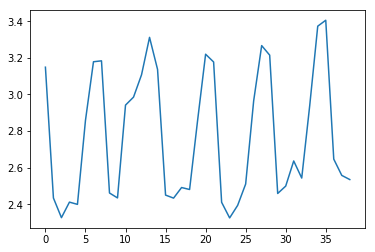

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.752569   
air_0164b9927d20bcc3_2017-04-23              1.322604   
air_0241aa3964b7f861_2017-04-23              2.394651   
air_0328696196e46f18_2017-04-23              2.164625   
air_034a3d5b40d5b1b1_2017-04-23              3.499892   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.769403  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.753182  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.964367  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.711332  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.111858

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/l4_3000_ridge_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')